## Predict Light Sheet Vessels

In [1]:
import napari
viewer = napari.Viewer()

from skimage.io import imread
from pathlib import Path
import torch
import numpy as np
from tnia.deeplearning.dl_helper import quantile_normalization
from torchvision import transforms
from torchvision.transforms import v2

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist


## Setup paths

In [2]:
from pathlib import Path
import os
tnia_images_path = Path("D:/images/tnia-python-images")
tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2025_03_19_vessel_3D_lightsheet3"
models_path = parent_path / 'models'

im_name = 'image_175.tif'
im = imread(str(parent_path / (im_name)))

## Load unet

In [3]:
net = torch.load( Path(models_path) / 'model_march22.pth' )
device = torch.device("cuda")
net.to(device)

/tmp/ipykernel_145237/3357803421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load( Path(models_path) / 'model_march22.pth' )
/home/bnorthan/mambaforge/en

BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False

## Apply unet

In this cell we apply the unet.  

1.  We have to normalize (need to make sure we normalize the same way as the network was trained)
2.  Convert to tensor
3.  Add batch num and channel dimensions with unsqueeze
4.  calculate logits
5.  (in a subsequent cell) use softmax and argmax to convert logits to predictions


In [4]:
help(sliding_window_inference)

NameError: name 'sliding_window_inference' is not defined

In [5]:
# Visualize predictions
from tnia.deeplearning.dl_helper import quantile_normalization

#im, raw = train_dataset[10]

net.eval()

print(im.shape, im.min(), im.max())
im = quantile_normalization(im)
im = im.astype(np.float32)
print(im.shape, im.min(), im.max())
im_tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0).to(device)       
print(im_tensor.shape)

'''
with torch.no_grad():
    logits=net(im_tensor)
'''
from monai.inferers import sliding_window_inference

with torch.no_grad():
    #logits = net(im_tensor)  # Forward pass through the model
    # Sliding window inference
    logits = sliding_window_inference(
        im_tensor,                      # Input tensor
        256,              # Patch size
        1,                       # Batch size during inference
        net,              # Model for inference
        #overlap=0.125          # Overlap factor

    )

(3080, 2868) 166 4598
(3080, 2868) 0.0 1.0
torch.Size([1, 1, 3080, 2868])


## Plot logits

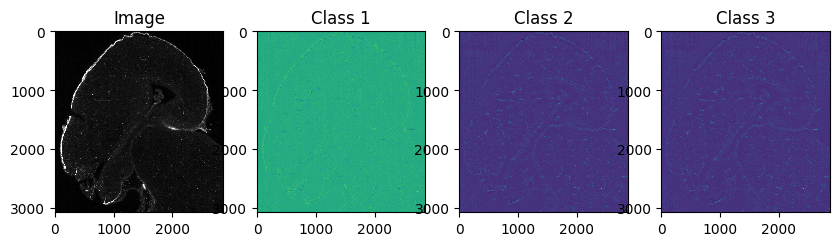

In [6]:
from tnia.plotting.plt_helper import imshow_multi2d

#im = np.transpose(im, (1,2,0))

logits.shape
c1 = logits[0,0,:,:].cpu().detach().numpy()
c2 = logits[0,1,:,:].cpu().detach().numpy()
c3 = logits[0,1,:,:].cpu().detach().numpy()

fig = imshow_multi2d([im, c1, c2, c3], ['Image', 'Class 1', 'Class 2', 'Class 3'], 1, 4, 10, 10,colormaps=['gray', 'viridis', 'viridis', 'viridis'])

In [7]:
viewer.add_image(im, name='Image', colormap='gray')
viewer.add_image(c1, name='Class 1')
viewer.add_image(c2, name='Class 2')

<Image layer 'Class 2' at 0x78dff8c7f560>

In [8]:
print(c1.min(), c1.max())
print(c2.min(), c2.max())
print(c3.min(), c3.max())

-17.579327 10.817419
-7.2011456 39.0975
-7.2011456 39.0975


## Convert logits to predictions

In [9]:
print(logits.shape)
import torch.nn.functional as F

# Apply softmax along the class dimension (dim=1)
probabilities = F.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1) 

torch.Size([1, 2, 3080, 2868])


In [10]:
#viewer = napari.Viewer()
viewer.add_image(im)
#viewer.add_labels(labels)
viewer.add_image(c1)
viewer.add_image(c2)
viewer.add_image(c3)
viewer.add_labels(predicted_classes.cpu().numpy()+1)

<Labels layer 'Labels' at 0x78e0360325a0>

## Label grains

Use skimage to label the grains.  If the boundaries are continuous, the grains should be well separated.  If there are breaks in the boundaries then clusters of grains may merge together. 

In [30]:
from skimage.measure import label

objects = (predicted_classes == 1).cpu().numpy()
lables = label(objects)

viewer.add_labels(lables)

<Labels layer 'lables [1]' at 0x7a3135a13260>